<a href="https://colab.research.google.com/github/abdulalimrakib/Stop-Sign-Detective-with-raw-python/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from skimage.feature import hog, local_binary_pattern
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from scipy.ndimage import rotate
from skimage import exposure
from sklearn.neighbors import KNeighborsClassifier
import warnings

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
dataset_path = "/content/drive/MyDrive/CSE 445/Dataset"
categories = ["Non stop sign", "Stop sign"]
IMG_SIZE = 100

data = []
labels = []
original_images = []

for label, category in enumerate(categories):
    folder_path = os.path.join(dataset_path, category)
    all_images = os.listdir(folder_path)
    print(f"Number of {category} images: {len(all_images)}")
    for single_image in all_images:
        img_path = os.path.join(folder_path, single_image)
        try:
            image = cv2.imread(img_path)
            if image is None:
                print(f"Failed to load: {img_path}")
                continue
            original_images.append(image)
            img = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            data.append(img)
            labels.append(label)
        except Exception as e:
            print(f"Error processing {img_path}: {e}")

data = np.array(data)
labels = np.array(labels)

print(f"Class distribution: Non stop sign: {np.sum(labels == 0)}, Stop sign: {np.sum(labels == 1)}")

Number of Non stop sign images: 65
Number of Stop sign images: 56
Class distribution: Non stop sign: 65, Stop sign: 56


Augmented dataset shape: (968, 100, 100, 3)
Augmented class distribution: Non stop sign: 520, Stop sign: 448


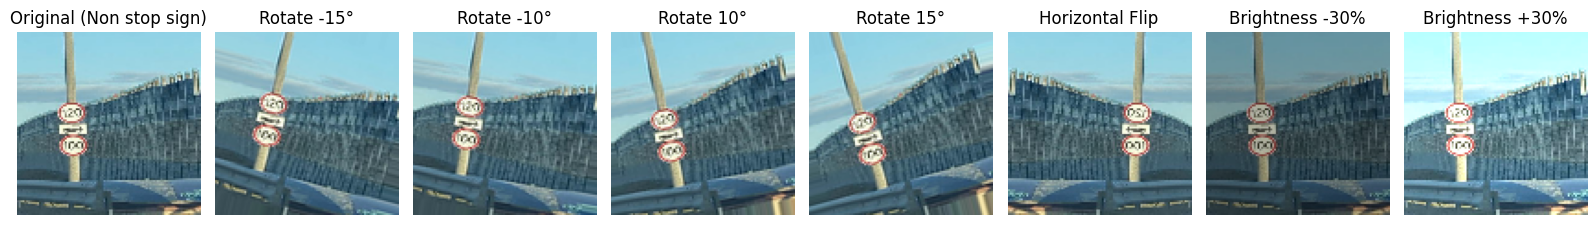

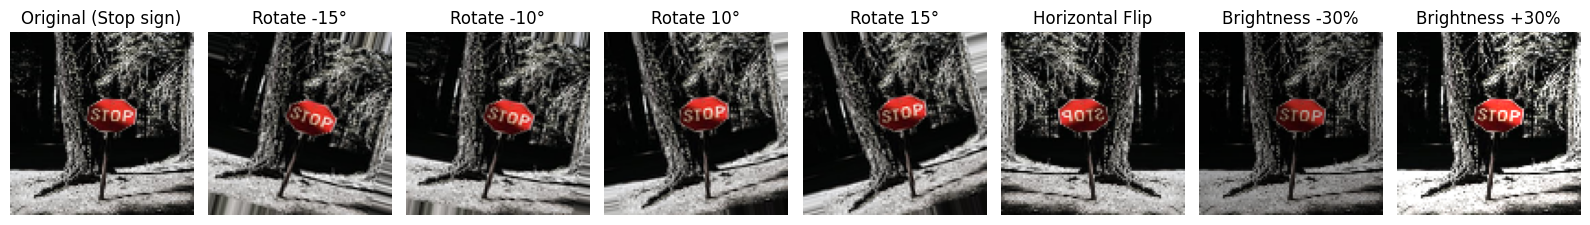

In [11]:
# Data augmentation functions
def augment_image(image):
    augmented_images = []

    # Original image
    augmented_images.append(image)

    # 1. Rotation (±15, ±10 degrees)
    for angle in [-15, -10, 10, 15]:
        rotated = rotate(image, angle, reshape=False, mode='nearest')
        augmented_images.append(rotated)

    # 2. Horizontal flip
    flipped_h = cv2.flip(image, 1)
    augmented_images.append(flipped_h)

    # 3. Brightness adjustment (±30%)
    image_pil = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    for factor in [0.7, 1.3]:
        enhancer = Image.fromarray(np.array(image_pil).astype(np.uint8))
        bright_img = np.array(enhancer) * factor
        bright_img = np.clip(bright_img, 0, 255).astype(np.uint8)
        bright_img = cv2.cvtColor(bright_img, cv2.COLOR_RGB2BGR)
        augmented_images.append(bright_img)

    return augmented_images

# Augment the dataset
augmented_data = []
augmented_labels = []

for img, label in zip(data, labels):
    aug_imgs = augment_image(img)
    augmented_data.extend(aug_imgs)
    augmented_labels.extend([label] * len(aug_imgs))

# Convert augmented data to NumPy arrays
augmented_data = np.array(augmented_data)
augmented_labels = np.array(augmented_labels)

# Print augmented class distribution
print(f"Augmented dataset shape: {augmented_data.shape}")
print(f"Augmented class distribution: Non stop sign: {np.sum(augmented_labels == 0)}, Stop sign: {np.sum(augmented_labels == 1)}")

# Optional: Visualize a few augmented images
def visualize_augmented_images(original_img, aug_imgs, label, category):
    plt.figure(figsize=(16, 3))  # Adjusted figure size for 8 subplots
    plt.subplot(1, 8, 1)  # Changed to 1x8 grid
    plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Original ({category})")
    plt.axis('off')

    titles = ['Rotate -15°', 'Rotate -10°', 'Rotate 10°', 'Rotate 15°', 'Horizontal Flip', 'Brightness -30%', 'Brightness +30%']
    for i, aug_img in enumerate(aug_imgs[1:], 2):  # Skip original image
        plt.subplot(1, 8, i)  # Changed to 1x8 grid
        plt.imshow(cv2.cvtColor(aug_img, cv2.COLOR_BGR2RGB))
        plt.title(titles[i-2])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize one example from each class
for label, category in enumerate(categories):
    idx = np.where(labels == label)[0][0]  # Get first image index for this class
    aug_imgs = augment_image(data[idx])
    visualize_augmented_images(data[idx], aug_imgs, label, category)

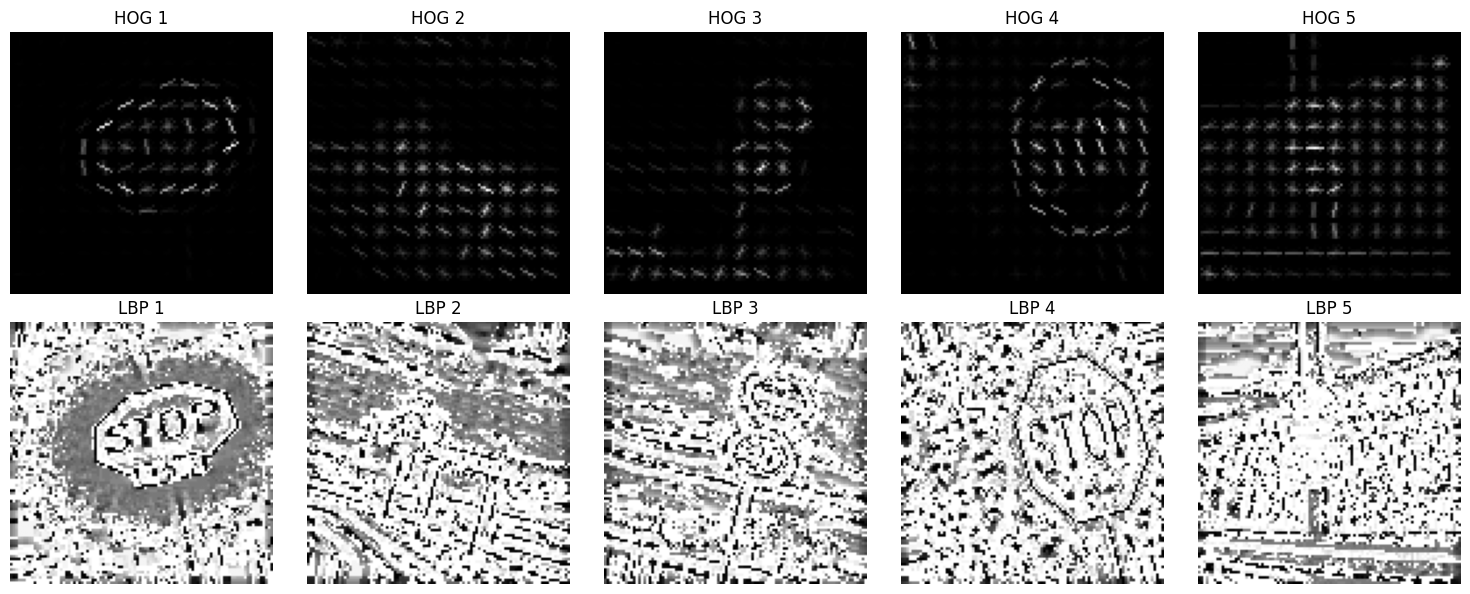

Original feature shape: (968, 4382), Reduced feature shape: (968, 461), PCA components: 461
Training set: 774 samples, Testing set: 194 samples


In [15]:
# Feature extraction functions
def extract_hog_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    features, hog_image = hog(
        gray, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2),
        block_norm='L2-Hys', visualize=True
    )
    hog_image = exposure.rescale_intensity(hog_image, out_range=(0, 255))
    hog_image = hog_image.astype(np.uint8)
    return features, hog_image

def extract_lbp_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    radius = 3
    n_points = 8 * radius
    lbp = local_binary_pattern(gray, n_points, radius, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), density=True)
    return hist, lbp

# Extract features from augmented dataset and visualize 5 random samples in two lines
features = []
random_indices = np.random.choice(len(augmented_data), 5, replace=False)
plt.figure(figsize=(15, 6))  # Adjusted for two rows

for idx in range(len(augmented_data)):
    img = augmented_data[idx]
    hog_features, hog_vis = extract_hog_features(img)
    lbp_features, lbp_vis = extract_lbp_features(img)
    combined_features = np.concatenate([hog_features, lbp_features])
    features.append(combined_features)

    if idx in random_indices:
        pos = np.where(random_indices == idx)[0][0]
        # HOG visualization (top row)
        plt.subplot(2, 5, pos + 1)
        plt.imshow(hog_vis, cmap='gray')
        plt.title(f'HOG {pos+1}')
        plt.axis('off')
        # LBP visualization (bottom row)
        plt.subplot(2, 5, pos + 6)
        plt.imshow(lbp_vis, cmap='gray')
        plt.title(f'LBP {pos+1}')
        plt.axis('off')

plt.tight_layout()
plt.savefig('feature_extraction.png', bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()

# Convert features to NumPy array
features = np.array(features)

# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Apply PCA to reduce dimensionality
pca = PCA(n_components=0.95)
features_reduced = pca.fit_transform(features_scaled)

# Print feature shapes in one line
print(f"Original feature shape: {features.shape}, Reduced feature shape: {features_reduced.shape}, PCA components: {pca.n_components_}")

# Split the dataset and print sizes in one line
X_train, X_test, y_train, y_test = train_test_split(features_reduced, augmented_labels, test_size=0.2, random_state=42, stratify=augmented_labels)
print(f"Training set: {X_train.shape[0]} samples, Testing set: {X_test.shape[0]} samples")

In [13]:
# Feature Preprocessing
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Best parameters: {'metric': 'euclidean', 'n_neighbors': 3}
Best cross-validation accuracy: 0.9044
Test set accuracy: 0.9330

Classification Report:
               precision    recall  f1-score   support

Non stop sign       0.89      1.00      0.94       104
    Stop sign       1.00      0.86      0.92        90

     accuracy                           0.93       194
    macro avg       0.94      0.93      0.93       194
 weighted avg       0.94      0.93      0.93       194



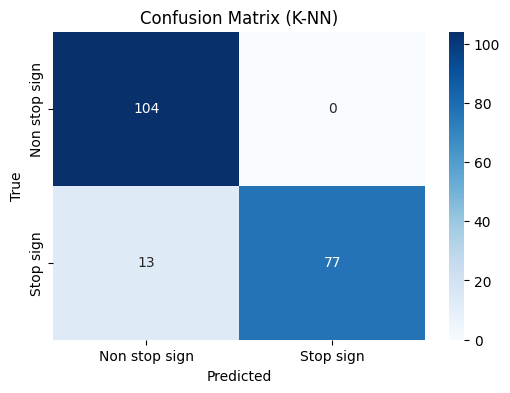

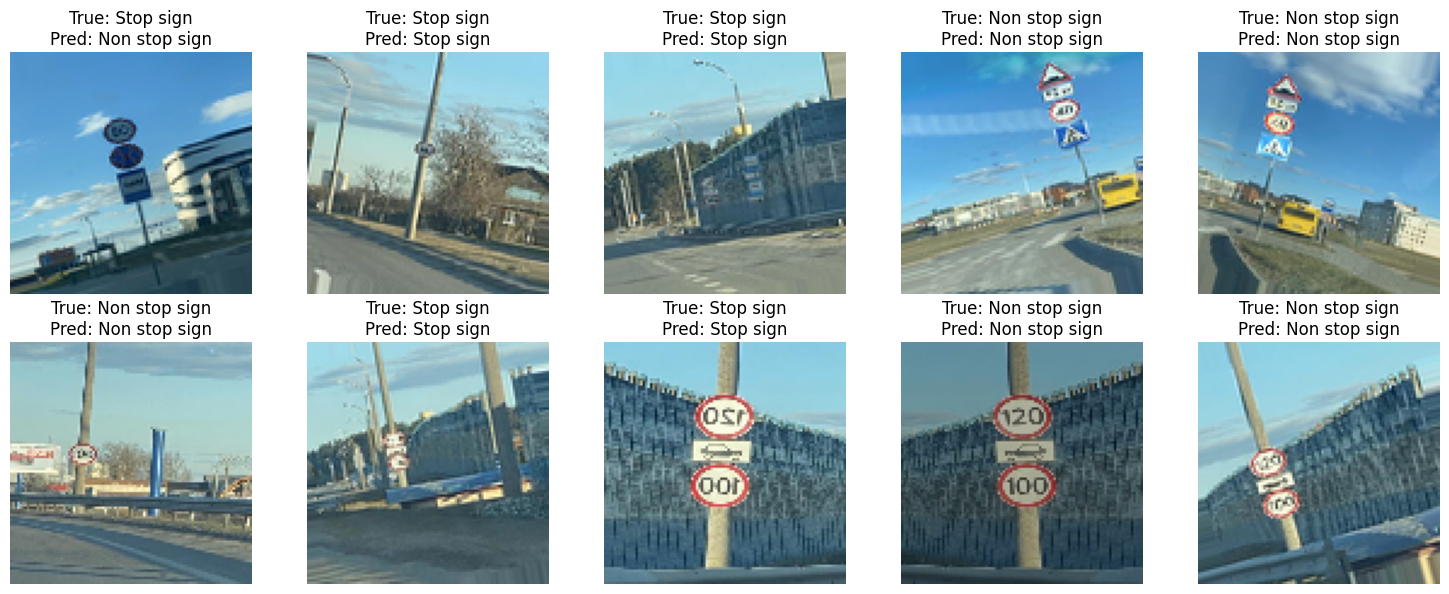

In [14]:
#K-NN model
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'metric': ['euclidean', 'manhattan']
}
knn = KNeighborsClassifier()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(knn, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

# Evaluate on test set
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {test_accuracy:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=categories))

# Compute and plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix (K-NN)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Display 10 random predictions
# Get indices of test set in the augmented dataset
test_indices = np.where(np.isin(augmented_labels, y_test))[0][np.random.choice(len(y_test), 10, replace=False)]
random_indices = np.random.choice(len(y_test), 10, replace=False)
random_X_test = X_test[random_indices]
random_y_test = y_test[random_indices]
random_y_pred = best_model.predict(random_X_test)

# Map test indices back to augmented_data indices
test_data_indices = np.arange(len(augmented_data))[np.isin(np.arange(len(augmented_data)), np.where(np.isin(augmented_labels, y_test))[0])]
random_test_data_indices = test_data_indices[random_indices]

# Visualize 10 random predictions
plt.figure(figsize=(15, 6))
for i, idx in enumerate(random_indices):
    img_idx = random_test_data_indices[i]
    img = augmented_data[img_idx]
    true_label = categories[random_y_test[i]]
    pred_label = categories[random_y_pred[i]]

    plt.subplot(2, 5, i + 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis('off')
plt.tight_layout()
plt.show()